In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from matplotlib import gridspec ## for composite figures
import matplotlib.patheffects as path_effects ## for elegant text
from IPython.display import HTML
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch


def colourDict(data,cmap=mpl.cm.viridis):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name
    """
    cmap=cmap # default viridis
    data_unique=sorted(list(set(data))) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

def legend(dictionary,marker='o',markersize=15,labelspacing=1,fontsize=10,ax='',style='italic',loc='best',bbox_to_anchor=(0.5, 0.5),fontname='Arial'): # `'upper left', 'upper right', 'lower left', 'lower right'
    """ Returns a legend object from a dictionary"""
    legend_elements=[]
    for key,value in dictionary.items():
        legend_elements.append(Line2D([0],[0],marker=marker,color=value,label=key,markersize=markersize))
    leg=ax.legend(handles=legend_elements, loc=loc,labelspacing=labelspacing,prop={'size': fontsize,'style':style,'family':fontname},bbox_to_anchor=bbox_to_anchor)
    return leg

# Load raster

In [3]:
# loading the raster
raster=pd.read_csv('../data/colombia_low_low.asc',skiprows=6,sep=' ',header=None,dtype='float')
# masks the cells with nule data using the value asigned by qgis
rasterplot=raster.mask(np.isclose(raster.values,3.4028234663852885981e+38,rtol=0.00001))
# replacing sea cells with np.nan
raster.replace(0,np.nan,inplace=True)
# raster information
nrows=6480;ncols=4680
xmin=-79.000138889000;xmax=-65.9998611112399942
ymin=-5.000245726692;ymax=13.0001388886679976
cellsize=0.002777837132

# cellsize of the raster
xcell=((xmin-xmax)/ncols)*-1
ycell=(ymax-ymin)/nrows
print(xcell,ycell)

0.002777837132000001 0.0027778371319999995


# Load shade polygons

In [4]:
# loading the polygons to shade countries other than Colombia
json_path='../data/col_borders4.geojson'
json_map=json.load(open(json_path,'r'))
features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here
locName='LEVEL3_COD' ## key name for each feature
total_area={} # keep track of the area of country polygones, for filtering purposes
for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=loc['properties'][locName] ## standardised location name (remove diacritics)
    polygons[location]=[]
    location_points[location]=[]
    total_area[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        totalarea=0
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                # transforming the coordinates into column and row indices of the raster
                xs=(coords[:,0]-xmin)//cellsize ## longitudes
                ys=(6480-(coords[:,1]-ymin)//cellsize) ## latitudes
                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            # transforming the coordinates into column and row indices of the raster
            xs=(coords[:,0]-xmin)//cellsize ## longitudes
            ys=(6480-(coords[:,1]-ymin)//cellsize) ## latitudes
            location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location
    polygons[location]=complete_location ## assign list of polygons to a location

C:\Python3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Python3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


# Load trees

In [5]:
antmcct_path='../data/Azteca_exp_strict_ITS2_min_mcct.tre'

anttree=bt.loadNexus(antmcct_path,absoluteTime=False)
anttree.traverse_tree()
anttree.treeStats()
anttree.drawTree()


Tree height: 48.182534
Tree length: 1195.351047
strictly bifurcating tree
annotations present

Numbers of objects in tree: 579 (289 nodes and 290 leaves)



# Load data

In [6]:
data=pd.read_csv('../data/coordinates_of_plants_and_ants.csv',sep=',')
# transform coordinates into column and row index of the raster
data['longs']=(data['Longitude']-xmin)//cellsize
data['lats']=(6480-(data['Latitude']-ymin)//cellsize)

# the localities are near the political border and there are no biogeographical barriers between the two. 
data.replace('Boyaca','Casanare')
data

# filtering out collections of plants from other species that are not included in the analyses
datatococa=data[(data['Plant']=='Tococa guianensis') | (data['Plant']=='Tococa')]
datatococa

,Plant,Ant,Collection,Department,Locality,Area (RASP),Latitude,Longitude,Altitude (m),longs,lats
0,Tococa,Azteca,MFT147,Amazonas,Leticia,NaN,-4.120033,-69.956267,92.0,3255.0,6164.0
1,Tococa,Azteca,MFT148,Amazonas,Leticia,NaN,-4.120033,-69.956267,92.0,3255.0,6164.0
2,Tococa,Azteca,MFT341,Valle del Cauca,Buenaventura,NaN,3.970110,-77.003260,66.0,718.0,3251.0
3,Tococa,Azteca,MFT397,Antioquia,San Carlos,NaN,6.194390,-75.005780,1111.0,1437.0,2451.0
4,Tococa,Azteca,MFT410,Putumayo,Villagarzon,NaN,1.060820,-76.622430,515.0,855.0,4299.0
...,...,...,...,...,...,...,...,...,...,...,...
353,Tococa guianensis,Tapinoma,MFT218,Choco,Arusi,NaN,5.571650,-77.502010,60.0,539.0,2675.0
354,Tococa guianensis,Tapinoma,MFT247,Choco,Arusi,NaN,5.575040,-77.497330,89.0,540.0,2673.0
355,Tococa guianensis,Wasmania,MFT387,Antioquia,San Luis,NaN,6.048130,-74.990980,988.0,1443.0,2503.0
356,Tococa guianensis,Wasmania,MFT389,Antioquia,San Luis,NaN,6.194370,-75.005480,1084.0,1438.0,2451.0


In [78]:
data['Locality'].unique()

array(['Leticia', 'Buenaventura', 'San Carlos', 'Villagarzon', 'Arusi',
       'S.J. de Arama', 'San Luis', 'Cimitarra', 'Villavicencio',
       'Acacías', 'Villanueva', 'Tauramena', 'Amalfi', 'Barrancabermeja',
       'Puerto Nariño', 'Anolaima', 'Payande', 'Cocora', 'Calarca',
       'Quimbaya', 'Manizales', 'Padua', 'Mariquita', 'Espinal', 'Calima',
       'Guayabal', 'El Cerrito', 'Barranca de Upia', 'San Luis de Gaceno',
       'Barbosa', 'Jamundi', 'Yolombo', 'Cali', 'Valdivia', 'Solano',
       'Puerto Gaitan'], dtype=object)

# Plot *Azteca* tree

In [80]:
# Dictionaries and lists
clist=[(0.0,'#737373'),
       (1.0,'#ffffff')]

cmap=mpl.colors.LinearSegmentedColormap.from_list('mycmap',clist)
# setting lists and dictionaries:
# all locations
locations=list(data['Locality'].unique())
# to add a space between locations within a single area (for the ancestral area reconstruction)
# dictionary of areas:colour for the ancestral area reconstructions
area_dict_col={'Santander':'#deebf7','Choco':'#08519c','Valle del Cauca':'#4292c6','Antioquia':'#9ecae1', # west
               'Casanare':'#fed976','Meta':'#fd8d3c','Putumayo':'#e31a1c','Amazonas':'#800026', # east
               'Cundinamarca':'#f1b6da', # East Magdalena river but west to Eastern Cordillera
               'Tolima':'#b8e186', # West Magdalena river and west to Eastern Cordillera
               'Quindio':'#4d9221',
                'none':'#a3a3a3'} # west
area_dict_RASP={'Santander':'G','Choco':'C','Valle del Cauca':'A','Antioquia':'E', # west
               'Casanare':'H','Meta':'D','Putumayo':'F','Amazonas':'B', # east
               'Cundinamarca':'K', # East Magdalena river but west to Eastern Cordillera
               'Tolima':'I', # West Magdalena river and west to Eastern Cordillera
               'Quindio':'J',
                'none':'N'} # west
                
area_dict={'Barrancabermeja':'Santander','Cimitarra':'Santander',
           'Anolaima':'Cundinamarca',
           'Payande':'Tolima','Cocora':'Tolima','Padua':'Tolima','Mariquita':'Tolima','Espinal':'Tolima','Guayabal':'Tolima',
           'Calarca':'Quindio','Quimbaya':'Quindio','Manizales':'Quindio',
           'Arusi':'Choco','Solano':'Choco',
           'Buenaventura':'Valle del Cauca','Calima':'Valle del Cauca','Cali':'Valle del Cauca','El Cerrito':'Valle del Cauca','Jamundi':'Valle del Cauca',
           'San Carlos':'Antioquia','San Luis':'Antioquia','Amalfi':'Antioquia','Yolombo':'Antioquia','Valdivia':'Antioquia','Barbosa':'Antioquia',
          'Tauramena':'Casanare','Villanueva':'Casanare','San Luis de Gaceno':'Casanare',
           'Villavicencio':'Meta','Acacías':'Meta','S.J. de Arama':'Meta','Barranca de Upia':'Meta','Puerto Gaitan':'Meta',
           'Villagarzon':'Putumayo',
           'Leticia':'Amazonas','Puerto Nariño':'Amazonas',
            'none':'none'}
# adding numbers
loc_tuples=[(index+1,loc) for index,loc in enumerate(locations)]
# dictionary ant genera:colour
ant_dict=colourDict(sorted(datatococa['Ant'].unique(), key=str.lower, reverse=False),cmap=mpl.cm.tab20b)
# dictionary location:location number
loc_num_dict=dict(zip([x[1] for x in loc_tuples],[x[0] for x in loc_tuples]))

# dictionary of tree_tip:locality
# make sure k.name corresponds to the info in data['Collection']
tiplocal_dict=dict(zip(data['Collection'],data['Locality']))
tiplocal_dict['none']='#a3a3a3'

# display name dictionary
tipdisplay_dict=dict(zip(data['Collection'],['%s %s'%(row.Ant,row.Collection) for row in data.itertuples()]))

# dictionary ant:plant
antplant_dict=dict(zip(data['Collection'],data['Plant']))

# annotate the Azteca tree nodes with the region
for k in anttree.Objects:
    if isinstance(k,bt.leaf): # iterates through the tip
        cur_node=k
        while cur_node:
            cur_node.traits['locality']=tiplocal_dict[k.name] if k.name in tiplocal_dict.keys() else 'none' # annotates the parental nodes with the genus name. Done for colouring the branches based on genera
            cur_node=cur_node.parent

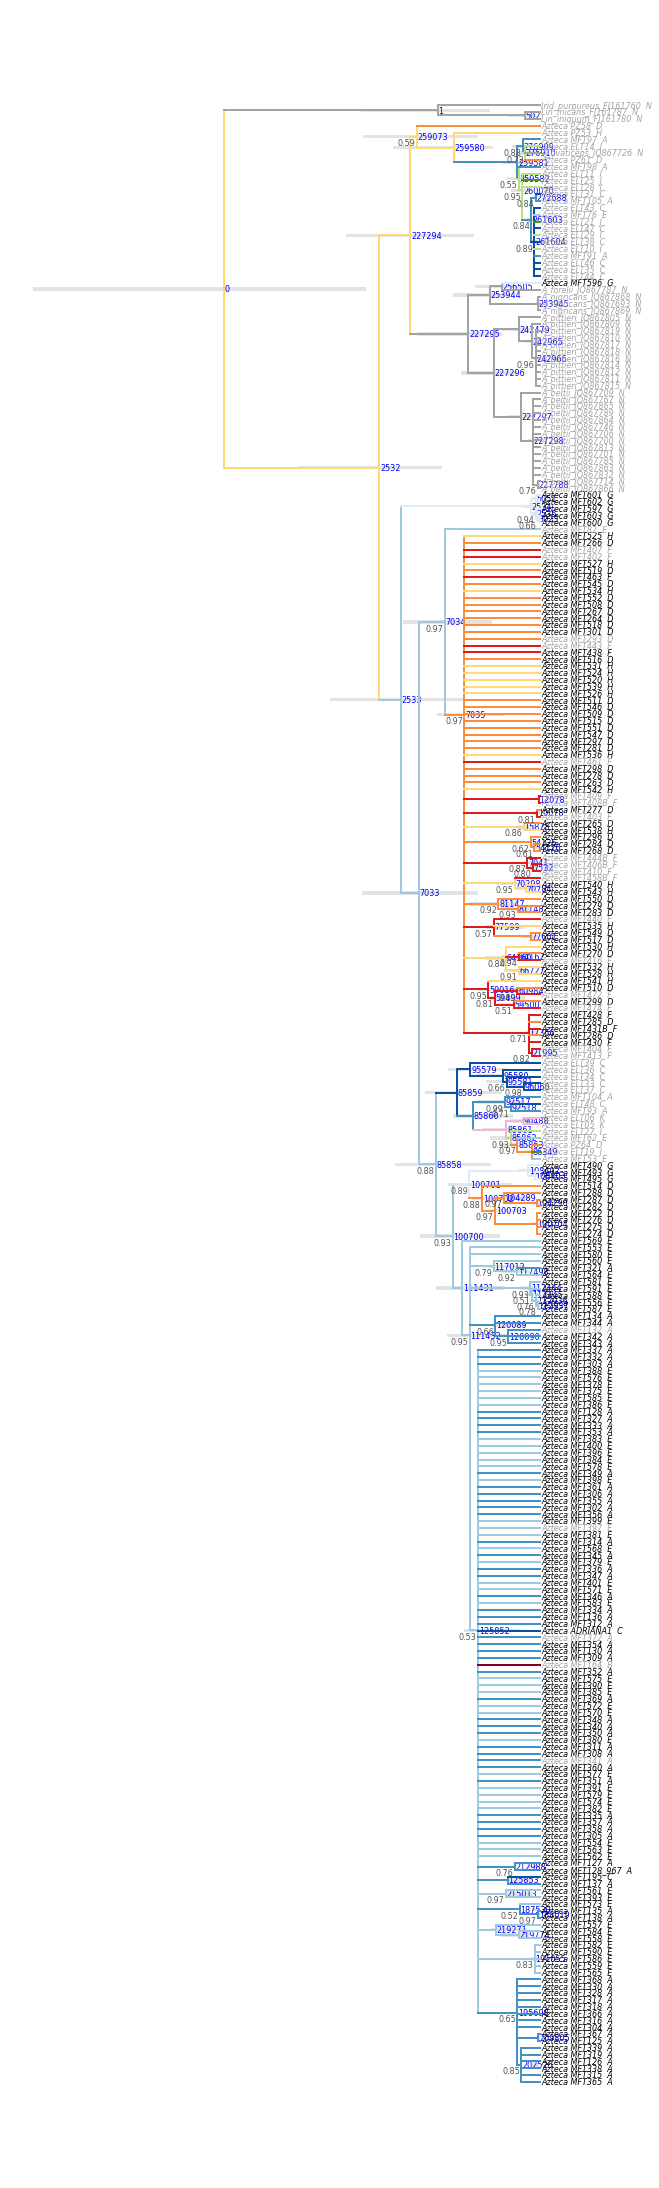

In [192]:
fig,ax = plt.subplots(figsize=(10,40),facecolor='none')

atree=anttree.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 2 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax,x_attr=x_attr,colour_function=bc_func,branchWidth=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        ax.text(k.x-atree.treeHeight+0.2,k.y,'%s  %s'%(tipdisplay_dict[k.name] if k.name in tipdisplay_dict.keys() else k.name,area_dict_RASP[area_dict[k.traits['locality']]]),
                va='center', ha='left',size=8,
                color='k' if k.name in tipdisplay_dict.keys() and k.name in antplant_dict.keys() and 'guianensis' in antplant_dict[k.name] else '#a3a3a3', style='italic')
    else:
        if 'posterior' in k.traits and k.traits['posterior'] < 0.99:
            ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='right',size=8,color='#545454',zorder=1000)
#             ax.text(k.height-0.001,k.y-0.16,'*',va='top',ha='right',size=28,color='#303030',zorder=1000)
        if  'height_95%_HPD' in k.traits:
            height=0.5
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.4)
            ax.add_patch(box)
        ax.text(k.x-atree.treeHeight+0.1,k.y,'%s'%(k.index),va='center', ha='left',size=8,color='b') # node index, to be able to flip the clades for the map

# ax.set_ylim(-5,anttree.ySpan+5)
# ax.set_xlim(-0.1,0.5)
# xlinebar=0.1175
# ax.text(xlinebar+0.025,49,'0.05',va='top',ha='center',size=25,color='#303030')
# ax.hlines(50,xlinebar,xlinebar+0.05,linestyle='solid',color='#c2c2c2',lw=4) 

plt.xticks([])
plt.yticks([])
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
# plt.savefig('./Azteca_mcct_20210106.pdf',pdi=300)
plt.show()

In [193]:
# 7033
# flippig the east and west clades for better plotting in the map
for k in atree.Objects:
    if k.index == 7033:
        k.children=k.children[::-1]
atree.drawTree()

# Plot Ant tree and map

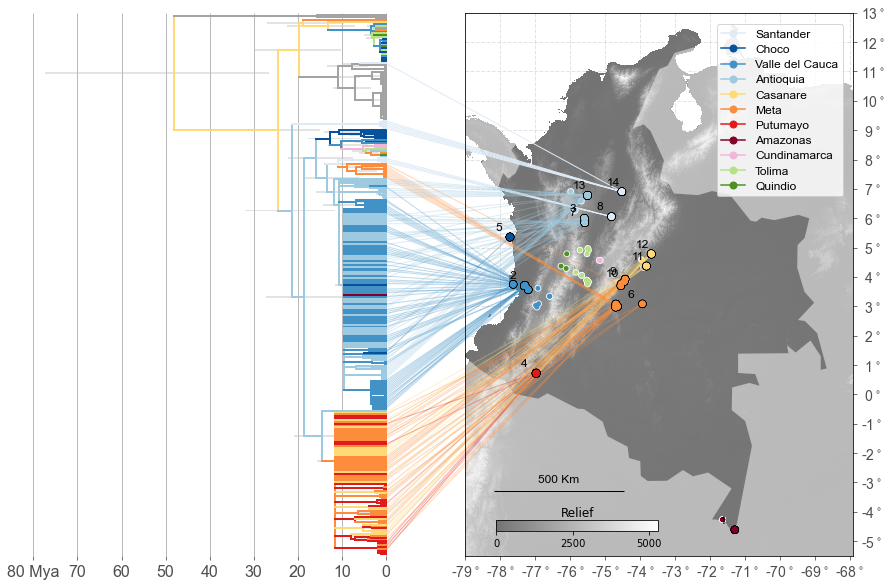

In [204]:
fig = plt.figure(figsize=(15,10),facecolor='w') 
G = gridspec.GridSpec(1,2,wspace=0.16,hspace=0.0)
ax1=plt.subplot(G[0,0],facecolor='none')
plt.ylim(-0.5,anttree.ySpan+0.5);#plt.xlim(48.5,-0.5)

# atree=anttree.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)

x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
b_func=lambda k: 2 ## branch width function
s_func=lambda k: 600-30*k.height/anttree.treeHeight ## size of tips
z_func=lambda k: 100

atree.plotTree(ax1,x_attr=x_attr,colour_function=bc_func,branchWidth=b_func) ## plot branches
for k in atree.Objects:
    if k.branchType!='leaf':
        if  'height_95%_HPD' in k.traits:
            height=1
            left=-k.traits['height_95%_HPD'][1]  # past to present
            bottom=k.y-(height/2) ## max-median
            width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
            box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.4)
            ax1.add_patch(box)
            
for x in range(0,90,10):
    ax1.vlines(x=-x,ymin=ax1.get_ylim()[0],ymax=ax1.get_ylim()[1],lw=1,ls='-',color='#bababa',alpha=1)

[ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
plt.yticks([])
plt.xticks(ticks=[-x for x in range(0,90,10)],labels=['%s'%(x) if x != 80 else '%s Mya'%(x) for x in range(0,90,10)],fontsize=16,fontname='Arial')
plt.tick_params(axis='x', which='both', pad=5,labelcolor='#4f4f4f',color='#4f4f4f')
# plt.xticks(color='#4f4f4f',fontsize=15)

# plotting the map
ax2=plt.subplot(G[0,1])
plt.xlim(0,ncols); plt.ylim(nrows,0)
# add grid behind
for y in range(0,6500,350):
    ax2.hlines(y=y,xmin=0,xmax=ncols,lw=1,ls='--',color='#bababa',zorder=1,alpha=0.4)
    
for x in range(int(ax2.get_xlim()[0]),int(ax2.get_xlim()[1]),422):
    ax2.vlines(x=x,ymin=0,ymax=int(ax2.get_xlim()[1]),lw=1,ls='--',color='#bababa',zorder=1,alpha=0.4)

vmin=1; vmax=5300
# lazy plotting the tiff
sns.heatmap(rasterplot,cmap=cmap,cbar=False,vmin=vmin,vmax=vmax,alpha=1,zorder=2,ax=ax2,xticklabels=False,yticklabels=False)

# plotting polygons to shade countries other than Colombia
for loc in polygons.keys():
    ax2.add_collection(PatchCollection(polygons[loc],facecolor='w',edgecolor='w',alpha=0.5,linewidth=0.1,zorder=2))
ax2.plot()
[ax2.spines[loc].set_visible(True) for loc in ['top','right','left','bottom']]
for loc in ax2.spines:
    sp=ax2.spines[loc]
    sp.set_zorder(6)

# adding the degrees on each axis
plt.xticks(labels=['%2.f$^\circ$'%(x) for x in range(-79,-67,1)],ticks=[x for x in range(int(ax2.get_xlim()[0]),int(ax2.get_xlim()[1]),422)],fontname='Arial',fontsize=14)
ax2.set_yticks(ticks=[y for y in range(0,6500,350)]) #,labels=['%2.f'%(y) for y in range(-5,13,1)],fontname='Arial',fontsize=15)
ax2.set_yticklabels(labels=['%2.f$^\circ$'%(y) for y in range(-5,14,1)][::-1],fontname='Arial',fontsize=14)
plt.tick_params(axis='both', which='major', pad=5,labelcolor='#4f4f4f',color='#4f4f4f')
ax2.yaxis.tick_right()

# plotting the collecting locations and their numbers
ax2.scatter(datatococa['longs'],datatococa['lats'],s=40,zorder=5,facecolor=datatococa['Locality'].map(area_dict).map(area_dict_col),edgecolor='none')
ax2.scatter(datatococa['longs'],datatococa['lats'],s=70,zorder=4,facecolor='k',alpha=1,edgecolor='none') # background
ax2.scatter(data['longs'],data['lats'],s=25,zorder=3,facecolor=data['Locality'].map(area_dict).map(area_dict_col),alpha=1,edgecolor='none') # other Azteca associated to Cecropia or other Melastomataceae plants
ax2.scatter(data['longs'],data['lats'],s=45,zorder=2,facecolor='w',alpha=1,edgecolor='none') # background

for row in datatococa.groupby(by=['Locality']).first().reset_index().itertuples(): # plot the population numbers using the first coordinate in the table
    if row.Locality != 'Solano':
        ax2.text(x=row.longs-180,y=row.lats-80,s='%s'%(loc_num_dict[row.Locality]),fontname='Arial',fontsize=12,zorder=5)

# legend
legend({key:value for key,value in area_dict_col.items() if key != 'none'},marker='o',fontsize=12,ax=ax2,loc='upper right',style='normal',bbox_to_anchor=(0.99,0.99),markersize=7,labelspacing=0.4) # (x, y, width, height)

# adding distance scale
ax2.hlines(y=5700,xmin=345,xmax=345+(350*4.5),lw=1,ls='-',zorder=3)
ax2.text(x=(345+345+(350*4.5))/2,y=5600,s='500 Km',fontsize=12,fontname='Arial',ha='center',zorder=3)

# adding colorbar
axcb=fig.add_axes([0.57,0.16, 0.15, 0.015], frame_on=False) # left(leftx) | bottom | width | height
cb=mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),orientation='horizontal',alpha=1.0,drawedges=False)#
axcb.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2500))
axcb.set_xlim(0,5300)
axcb.xaxis.set_label_position('top')
axcb.set_xlabel('Relief',size=12)

### in between plot lines
# plotting the connections:
for k in atree.getExternal():
    if k.name in list(datatococa['Collection']):
#         print(k.name)
        xyA=(k.x-atree.treeHeight,k.y) # in axes coordinates
        xyB=(float(data[data['Collection']==k.name]['longs']),float(data[data['Collection']==k.name]['lats'])) # x in axes coordinates, y in data coordinates
        coordsA = 'data'
        coordsB = 'data'
        con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,axesA=ax1,axesB=ax2,arrowstyle="-",clip_on=False,zorder=2,alpha=0.35 if area_dict[k.traits['locality']] != 'Santander' else 1,
                              color=area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3')
        ax2.add_artist(con)
# plt.savefig('./Fig_map_treeantcollections.pdf',bpi=300)
plt.show()